In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from math import log
from math import exp

In [2]:
loans = pd.read_csv('lending-club-data.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Extracting the target and the feature columns :

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)
target = 'safe_loans'
loans = loans[features + [target]]

Transform categorical data into binary features :

In [4]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)
        
for feature in categorical_variables:
    
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    loans_one_hot_encoded.fillna(0)
    #print loans_one_hot_encoded
    
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]

In [5]:
with open('module-8-assignment-2-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-8-assignment-2-test-idx.json') as test_data_file:    
    test_idx = json.load(test_data_file)

train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]

features = list(train_data.columns)
features.remove('safe_loans')

In [6]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    labels_in_node = np.array(labels_in_node)
    data_weights = np.array(data_weights)
    total_weight_positive = np.sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above

    # Sum the weights of all entries with label -1
    total_weight_negative = np.sum(data_weights[labels_in_node == -1])

    # Weight of mistakes for predicting all +1's is equal to the sum above

    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    if total_weight_positive >= total_weight_negative:
        return (total_weight_negative, +1)
    else:
        return (total_weight_positive, -1)

In [7]:
# If the data is identical in each feature, this function should return None
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))
    data['data_weights'] = data_weights
    
    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = left_split['data_weights']
        right_data_weights = right_split['data_weights']
        
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(np.array(left_split[target]), np.array(left_data_weights))
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(np.array(right_split[target]), np.array(right_data_weights))
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) * 1. / sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    # Return the best feature we found
    return best_feature

In [8]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None, 'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

In [9]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    
    data['data_weights'] = data_weights
    
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached."                )
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached."                )
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    """
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    """
    left_data_weights = np.array(left_split['data_weights'])
    right_data_weights = np.array(right_split['data_weights'])
    
    print ("Split on feature %s. (%s, %s)" % (splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [10]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Making predictions with a weighted decision tree :

In [11]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

Evaluating the tree :

In [12]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    
    # Once you've made the predictions, calculate the classification error
    
    return (data[target] != np.array(prediction)).values.sum() / float(len(data))

Example: Training a weighted decision tree 

In [13]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [14]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [15]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data. So we can get the same model as small_data_decision_tree_subset_20 if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in subset_20.

Implementing your own Adaboost (on decision stumps) :

In [16]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = np.sum(np.array(is_wrong) * alpha) * 1. / np.sum(alpha)
                
        # Compute model coefficient using weighted error
        weight = 1. / 2 * log((1 - weighted_error) * 1. / (weighted_error))
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        alpha = alpha * np.array(adjustment)
        alpha = alpha / np.sum(alpha)
    
    return weights, tree_stumps

Training a boosted ensemble of 10 stumps :

In [17]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------

In [18]:
def predict_adaboost(stump_weights, tree_stumps, data):
    
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        
        # Accumulate predictions on scores array
        scores = scores + stump_weights[i] * np.array(predictions)
    
    # return the prediction 
    return np.array(1 * (scores > 0) + (-1) * (scores <= 0))

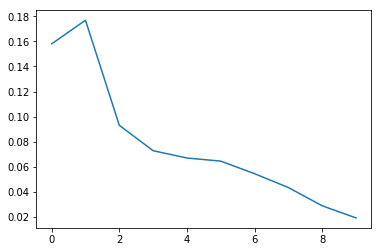

In [19]:
plt.plot(stump_weights)
plt.show()

The weights monotonically first increase and then initiate to decrease.

Performance plots :

In [20]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------

Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_4 years. (34593, 2631)
--------------------------------------------------------------------
Subtree, depth = 2 (34593 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (2631 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
--------------------------------------------------------------------
Subtree, depth = 2 (35512 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1712 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 17
---------------------------

Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


Computing training error at the end of each iteration :

In [21]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = np.sum(np.array(train_data[target]) != predictions) / float(len(predictions))
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4334300451321728
Iteration 3, training error = 0.40003761014399314
Iteration 4, training error = 0.40003761014399314
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.38461745110681284
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.38461745110681284
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3814474532559639
Iteration 11, training error = 0.3814474532559639
Iteration 12, training error = 0.3814474532559639
Iteration 13, training error = 0.3814474532559639
Iteration 14, training error = 0.3814474532559639
Iteration 15, training error = 0.3814474532559639
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
Itera

Visualizing training error vs number of iterations :

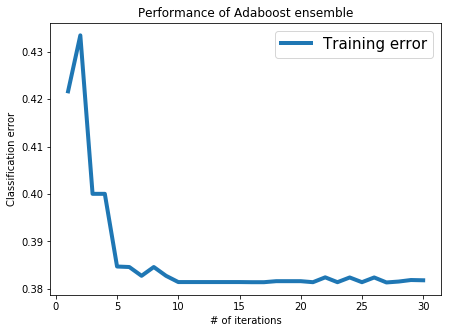

In [22]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

As we can see in the above plot, training error goes down in general, with some ups and downs in the middle.

Evaluation on the test data :

In [23]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = np.sum(np.array(test_data[target]) != predictions) / float(len(predictions))
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.42847910383455406
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.3799009047824214
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.3792546316242999
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.3792546316242999
Iteration 10, test error = 0.37796208530805686
Iteration 11, test error = 0.37796208530805686
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37796208530805686
Iteration 14, test error = 0.37796208530805686
Iteration 15, test error = 0.37796208530805686
Iteration 16, test error = 0.37817750969409736
Iteration 17, test error = 0.37817750969409736
Iteration 18, test error = 0.3778543731150366
Iteration 19, test error = 0.3778543731150366
Iteration 20, test error = 0.3778543731150366
Iteration 21, test error = 0.37817750969409736
Iteration 22, test error = 0.37

Visualize both the training and test errors :

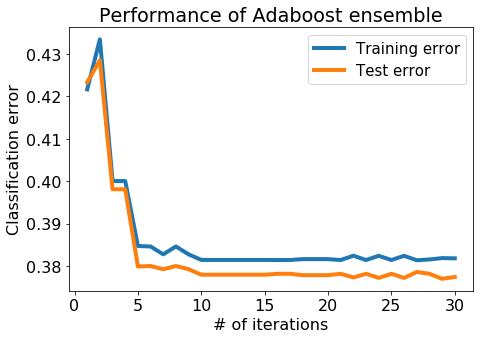

In [24]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

There is no massive overfitting as the number of iterations increases during the value of error, because due to increasing number of iteration the error didnt change so much (epsilon changes). 